# 手撸Transformer并摘引原文注解
#### 论文: 
+ [Attention Is All You Need](./Attention%20is%20all%20you%20need.pdf),arXiv:1706.03762v5 [cs.CL] 6 Dec 2017, 31st Conference on Neural Information Processing Systems (NIPS 2017), Long Beach, CA, USA.

#### 参考:
* http://nlp.seas.harvard.edu/2018/04/03/attention.html
* https://github.com/harvardnlp/annotated-transformer

#### 硬件要求：CPU

# Part 1: Transformer Implementation

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math, copy, time
import matplotlib.pyplot as plt
import seaborn

from torch.autograd import Variable
from IPython.display import Image

seaborn.set_context(context='talk')
%matplotlib inline

## Background
Self-attention, sometimes called intra-attention, is an attention mechanism relating different positions of a single sequence in order to compute a representation of the sequence.
End-to-end memory networks are based on attention mechanism instead of sequence aligned recurrence and have been shown to perform well on simple-language QA and language modeling tasks.

In [2]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. 
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequence."
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [3]:
class Generator(nn.Module):
    """
    Define standard linear + softmax generation step.
    """
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)
        
    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

## Encoder and Decoder Stacks
The Transformer follows this overall architecture using stacked self-attention and point-wise, fully connected layers for both the encoder and decoder, shown in the left and right halves of Figure 1, respectively.


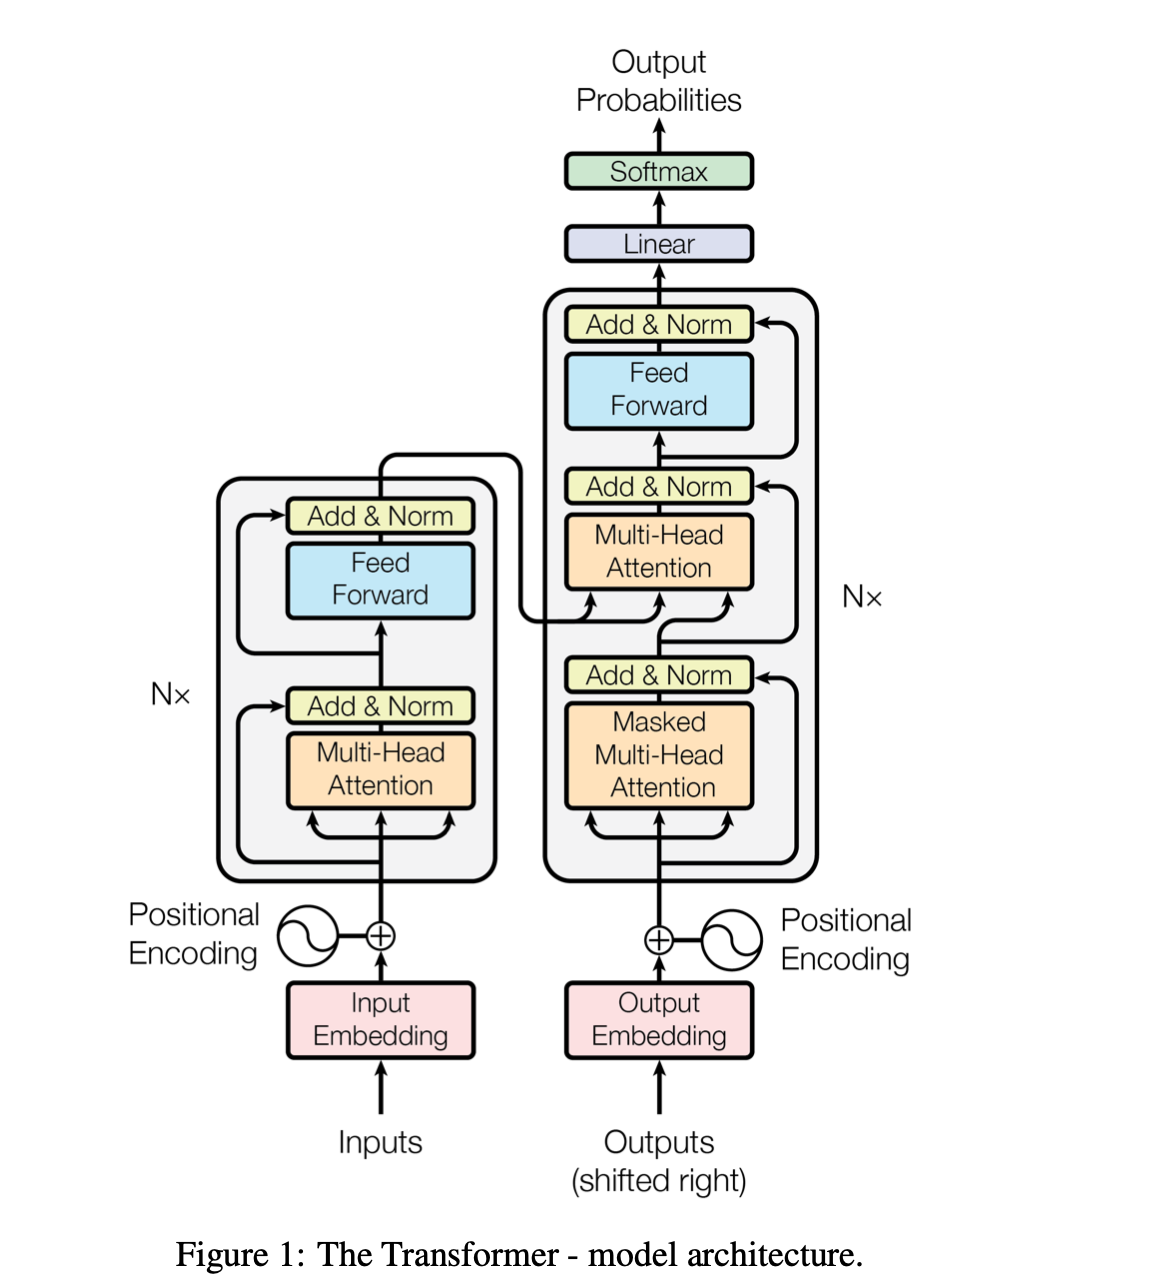

In [4]:
Image(filename='images/transformer-model.png')

## Encoder
The encoder is composed of a stack of N=6 identical layers.

In [5]:
def clones(module, N):
    """
    Produce N identical layers.
    """
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

We employ a residual connection around each of the two sub-layers, followed by layer normalization. That is, the output of each sub-layer is LayerNorm(x + Sublayer(x)), where Sublayer(x) is the function implemented by the sub-layer itself.

In [6]:
class LayerNorm(nn.Module):
    """
    Construct a layernorm module.
    """
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps
    
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        
        return self.a_2 * (x - mean)/(std + self.eps) + self.b_2

In [7]:
class Encoder(nn.Module):
    """
    Core encoder is a stack of N layers
    """
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        # print(f'Encoder layer.size={layer.size}')
    
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        
        return self.norm(x)

The output of each sub-layer is LayerNorm(x+Sublayer(x)), where Sublayer(x) is the function implemented by the sub-layer itself. We apply dropout to the output of each sub-layer, before it is added to the sub-layer input and normalized.
To facilitate these residual connections, all sub-layers in the model, as well as the embedding layers, produce outputs of dimension $d_{model}=512$.

Each layer has two sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position-wise fully connected feed-forward network.

In [8]:
class EncoderLayer(nn.Module):
    """
    Encoder is made up of self-attention and feed forward (defined below)
    """
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size
        
    def forward(self, x, mask):
        """
        Follow Figure 1 (left) for connections.
        """
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

In [9]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

## Decoder
The decoder is also composed of a stack of N=6 identical layers.

In [10]:
class Decoder(nn.Module):
    """
    Generic N layer decoder with masking
    """
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        # print(f'Decoder layer.size={layer.size}')
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In addition to the two sub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head attention over the output of the encoder stack. Similar to the encoder, we employ residual connections around each of the sub-layers, followed by layer normalization.

In [11]:
class DecoderLayer(nn.Module):
    """
    Decoder is made up of self-attention, src-attention and feed forward (defined below)
    """
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        """
        Follow Figure 1 (right) for connections.
        """
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

We also modify the self-attention sub-layer in the decoder stack to prevent positions from attending to subsequent positions. This masking, combined with fact that the output embeddings are offset by one position, ensures that the predictions for position 
i can depend only on the known outputs at positions less than i.

In [12]:
def subsequent_mask(size):
    """
    Mask out subsequent positions.
    """
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

tensor([[ True, False, False, False, False, False, False, False, False, False],
        [ True,  True, False, False, False, False, False, False, False, False],
        [ True,  True,  True, False, False, False, False, False, False, False],
        [ True,  True,  True,  True, False, False, False, False, False, False],
        [ True,  True,  True,  True,  True, False, False, False, False, False],
        [ True,  True,  True,  True,  True,  True, False, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True]])


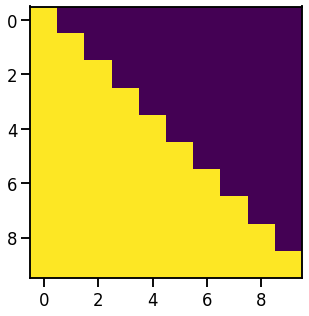

In [13]:
# Below the attention mask shows the position each tgt word (row) is allowed to look at (column).
# Words are blocked for attending to future words during training.
print(subsequent_mask(10)[0])
plt.figure(figsize=(5, 5))
plt.imshow(subsequent_mask(10)[0])
None

## Attention
An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.


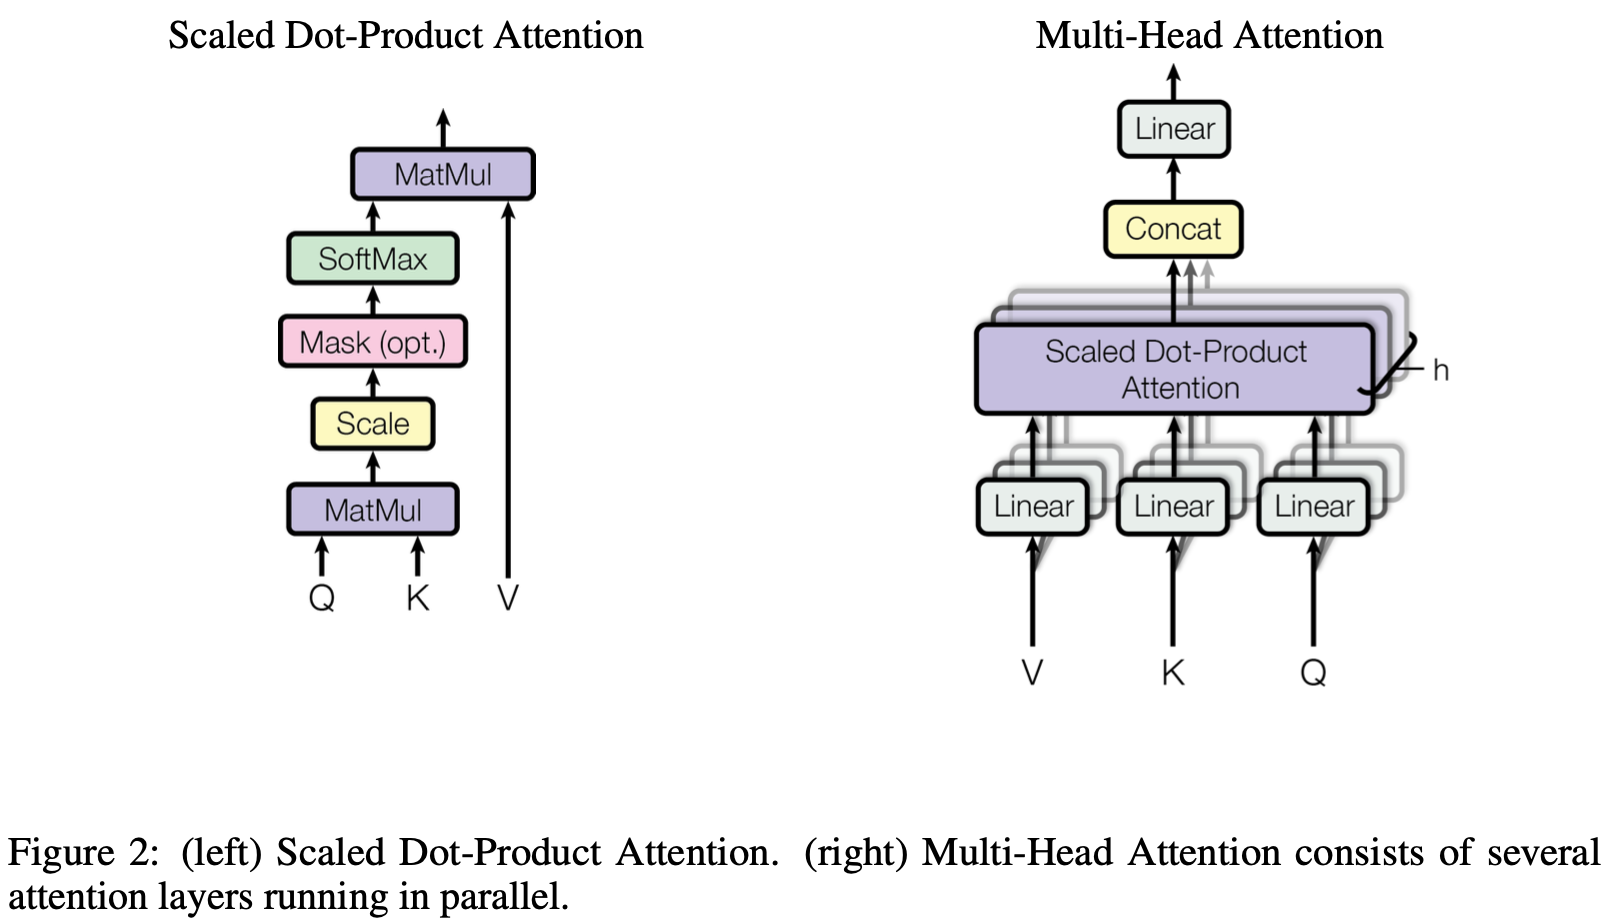

In [14]:
Image(filename='images/attention.png')

$$Attention(Q,K,V)=softmax(\frac{QK^T}{\sqrt{d_k}})V$$

In [15]:
def attention(query, key, value, mask=None, dropout=None):
    """
    Compute 'Scaled Dot-Product Attention', 
    Implements Figure 2: (left)
    """
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
        
    p_attn = F.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    
    return torch.matmul(p_attn, value), p_attn

Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this.
$$MultiHead(Q, K, V) = Concat(head_1, ..., head_h)W^O$$

where $$head_i = Attention(QW^Q_i, KW^K_i, VW^V_i)$$

Where the projections are parameter matrics $W^Q_i\in R^{d_{model}*d_Q}$, $W^K_i\in R^{d_{model}*d_K}$, $W^V_i\in R^{d_{model}*d_V}$, and $W^O\in R^{hd_v*d_{model}}$. 

In this work we employ h=8 parallel attention layers, or heads. For each of these we use $d_k=d_v=\frac{d_{model}}{h}=64. Due to the reduced dimension of each head, the head, the total computational cost is similar to that of single-head attention with full dimensionality.

In [16]:
class MultiHeadAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        """
        Take in model size and number of heads.
        """
        super(MultiHeadAttention, self).__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        """
        Implements Figure 2 (right).
        """
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2) 
            for l, x in zip(self.linears, (query, key, value))]
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)

        del query
        del key
        del value

        return self.linears[-1](x)

## Applications of Attention in our Model
The Transformer uses multi-head attention in three different ways:
+ In "encoder-decoder attention" layers, the queries come from the previous decoder layer, and the memory keys and values come from the output of the encoder. This allows every position in the decoder to attend over all positions in the input sequence.
+ The encoder contains self-attention layers. In a self-attention layer all of the keys, values and queries come from the same place, in this case, the output of the previous layer in the encoder. Each position in the encoder can attend to all positions in the previous layer of the encoder.
+ Similarly, self-attention layers in the decoder allow each position in the decoder to attend to all positions in the decoder up to and including that position. We need to prevent leftward information flow in the decoder to preserve the auto-regressive property. We implement this inside of scaled dot-product attention by masking out (setting to −∞) all values in the input of the softmax which correspond to illegal connections.


## Position-wise Feed-Forward Networks
In addition to attention sub-layers, each of the layers in our encoder and decoder contains a fully connected feed-forward network, which is applied to each position separately and identically. This consists of two linear transformations with a ReLU activation in between.

$$FFN(x)=max(0, xW_1 + b_1)W_2 + b_2$$

While the linear transformations are the same across different positions, they use different parameters from layer to layer. Another way of describing this is as two convolutions with kernel size 1. The dimensionality of input and output is $d_{model} = 512$, and the inner-layer has dimensionality $d_{ff} =2048$.

In [17]:
class PositionwiseFeedForward(nn.Module):
    """
    Implements FFN equation.
    """
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

## Embedding and Softmax
Similarly to other sequence transduction models, we use learned embeddings to convert the input tokens and output tokens to vectors of dimension $d_{model}$. We also use the usual learned linear transformation and softmax function to convert the decoder output to predicted next-token probabilities. In our model, we share the same weight matrix between the two embedding layers and the pre-softmax linear transformation. In the embedding layers, we multiply those weights by $\sqrt{d_{model}}$.

In [18]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model
        
    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

## Positional Encoding
We add "positional encodings" to the input embeddings at the bottoms of the encoder and decoder stacks. The positional encodings have the same dimension $d_{model}$ as the embeddings, so that the two can be summed. There are many choices of positional encodings, learned and fixed. In this work, we use sine and cosine functions of different frequencies:
$$PE_{(pos, 2i)}=sin(pos/10000^{2i/d_{model}})$$
$$PE_{(pos, 2i+1)}=cos(pos/10000^{2i/d_{model}})$$
where pos is the position and i is the dimension. That is, each dimension of the positional encoding corresponds to a sinusoid. The wavelengths form a geometric progression from 2π to 10000 · 2π. We chose this function because we hypothesized it would allow the model to easily learn to attend by relative positions, since for any fixed offset $k$, $PE_{pos+k}$ can be represented as a linear function of $PE_{pos}$.

In [19]:
class PositionalEncoding(nn.Module):
    """
    Implement the PE function.
    """
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)

        return self.dropout(x)


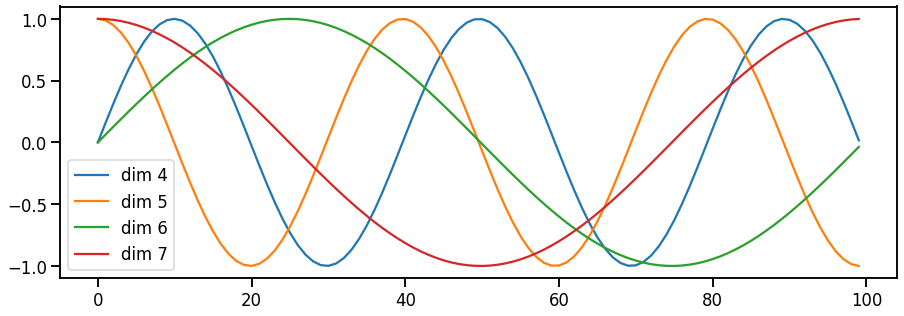

In [20]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
#print(y.shape)
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(['dim %d' %p for p in [4,5,6,7]])
None

We also experimented with using learned positional embeddings instead, and found that the two versions produced nearly identical results. We chose the sinusoidal version because it may allow the model to extrapolate to sequence lengths longer than the ones encountered during training.

## Full Model

In [21]:
def make_model(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    """
    Helper: Construct a model from hyperparameters.
    """
    c = copy.deepcopy
    attn = MultiHeadAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    # This was important from their code.
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

## Inference Test
Here we make a forward step to generate a prediction of the model. We try to use our transformer to memorize the input. As you will see the output is randomly generated due to the fact that the model is not trained yet. In the next tutorial we will build the training function and try to train our model to memorize the numbers from 1 to 10.

In [22]:
# Some convenience helper functions
RUN_EXAMPLES = True

def show_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        return fn(*args)

In [23]:
def inference_test():
    test_model = make_model(11, 11, 2)
    test_model.eval()
    src = torch.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])
    src_mask = torch.ones(1, 1, 10)

    memory = test_model.encode(src, src_mask)
    ys = torch.zeros(1, 1).type_as(src)

    for i in range(9):
        out = test_model.decode(
            memory, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data)
        )
        prob = test_model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat(
            [ys, torch.empty(1, 1).type_as(src.data).fill_(next_word)], dim=1
        )

    print("Example Untrained Model Prediction:", ys)


def run_tests():
    for _ in range(10):
        inference_test()


show_example(run_tests)

/Users/fenghaoguo/opt/anaconda3/envs/ng/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Example Untrained Model Prediction: tensor([[ 0, 10, 10, 10,  9,  9,  9,  9,  9,  9]])
Example Untrained Model Prediction: tensor([[0, 6, 6, 6, 6, 6, 6, 6, 6, 6]])
Example Untrained Model Prediction: tensor([[0, 2, 2, 2, 2, 2, 2, 2, 2, 2]])
Example Untrained Model Prediction: tensor([[ 0,  9, 10,  4,  5,  4,  5,  1,  9,  4]])
Example Untrained Model Prediction: tensor([[0, 1, 0, 1, 0, 1, 0, 1, 0, 1]])
Example Untrained Model Prediction: tensor([[0, 3, 5, 3, 0, 0, 0, 0, 0, 0]])
Example Untrained Model Prediction: tensor([[0, 9, 9, 9, 9, 9, 9, 9, 9, 9]])
Example Untrained Model Prediction: tensor([[0, 6, 8, 1, 3, 9, 6, 7, 7, 7]])
Example Untrained Model Prediction: tensor([[0, 5, 7, 4, 5, 7, 8, 5, 5, 5]])
Example Untrained Model Prediction: tensor([[ 0,  4,  0,  4,  3, 10,  4,  2,  3, 10]])


In [24]:
tmp_model = make_model(10, 10, 2)
None

/Users/fenghaoguo/opt/anaconda3/envs/ng/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


# Part 2 Training And Applying- Simple Example 1

## Batches and Masking
Define a batch object that holds the src and target sentences for training, as well as constructing the masks.

In [25]:
class Batch:
    """
    Object for holding a batch of data with mask during training.
    """
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        """
        Create a mask to hide padding and future words.
        """
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

## Training Loop

Create a generic training and scoring function to keep track of loss. We pass in a generic loss compute function that also handles parameter updates.

In [26]:
def run_epoch(data_iter, model, loss_compute):
    """
    Standard Training and Logging Function
    """
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg,
                           batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" % (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0

    return total_loss / total_tokens

## Training Data and Batching

We will use torch text for batching. This is discussed in more detail below. Here we create batches in a torchtext function that ensures our batch size padded to the maximum batchsize does not surpass a threshold (25000 if we have 8 gpus).

In [27]:
global max_src_in_batch, max_tgt_in_batch

def batch_size_fn(new, count, sofar):
    """
    Keep augmenting batch and calculate total number of tokens + padding.
    """
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch, len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch, len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch

    return max(src_elements, tgt_elements)

# Optimizer

In [28]:
class NoamOpt:
    """
    Optim wrapper that implements rate.
    """
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
    
    def rate(self, step=None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) * 
             min(step ** (-0.5), step * self.warmup **(-1.5)))
    
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
                  torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

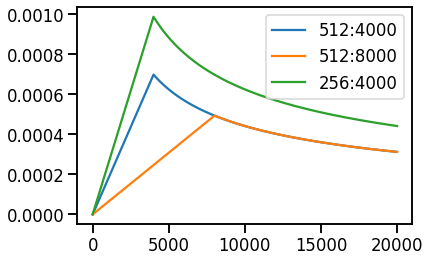

In [29]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None),
       NoamOpt(512, 1, 8000, None),
       NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(['512:4000', '512:8000', '256:4000'])
None

We used the Adam optimizer with $\beta_1=0.9$, $\beta_2=0.98$ and $\epsilon=10^{−9}$. We varied the learning rate over the course of training, according to the formula:

$$lrate=d^{-0.5}_{model}·min(step\_num^{−0.5}, step\_num·warmup\_steps^{−1.5})$$

This corresponds to increasing the learning rate linearly for the first warmup_steps training steps, and decreasing it thereafter proportionally to the inverse square root of the step number. We used warmup_steps = 4000.

Example of the curves of this model for different model sizes and for optimization hyperparameters.

## Regularization
### Label Smoothing

We implement label smoothing using the KL div loss. Instead of using a one-hot target distribution, we create a distribution that has confidence of the correct word and the rest of the smoothing mass distributed throughout the vocabulary.

In [30]:
class LabelSmoothing(nn.Module):
    """Implement label smoothing."""
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
    
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size-2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        
        return self.criterion(x, Variable(true_dist, requires_grad=False))

Here we can see an example of how the mass is distributed to the words based on confidence.

/Users/fenghaoguo/opt/anaconda3/envs/ng/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


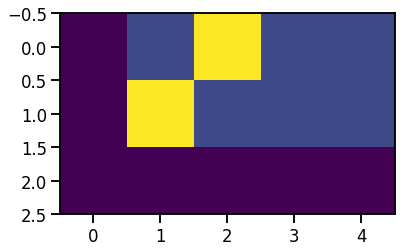

In [31]:
# Example of label smoothing
crit = LabelSmoothing(5, 0, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0], 
                            [0, 0.2, 0.7, 0.1, 0],
                            [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()),
        Variable(torch.LongTensor([2, 1, 0])))
# Show the target distributions expected by the system.
plt.imshow(crit.true_dist)
None

Label smoothing actually starts to penalize the model if it gets very confident about a given choice.

In [32]:
def loss(x, crit):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d],
                                 ])
    # print(predict)
    return crit(Variable(predict.log()), Variable(torch.LongTensor([1]))).data

# loss(3)

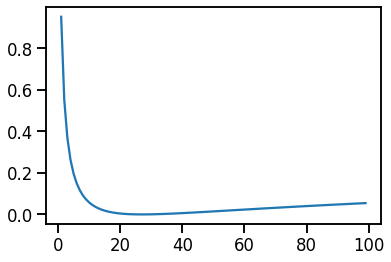

In [33]:
crit = LabelSmoothing(5, 0, 0.1)
plt.plot(np.arange(1, 100), [loss(x, crit=crit) for x in range(1, 100)])
None

## Synthetic Data

In [34]:
def data_gen(V, batch, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        data[:, 0] = 1.0
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        yield Batch(src, tgt, 0)

## Loss Computation

In [35]:
class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt

    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), y.contiguous().view(-1)) / norm
        loss.backward()

        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()

        return loss.data * norm

## Greedy Decoding

In [36]:
# Train the simple copy task.
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400,
                   torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(10):
    model.train()
    run_epoch(data_gen(V, 30, 20), model,
             SimpleLossCompute(model.generator, criterion, model_opt))
    model.eval()
    print(run_epoch(data_gen(V, 30, 5), model,
                   SimpleLossCompute(model.generator, criterion, None)))

/Users/fenghaoguo/opt/anaconda3/envs/ng/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Epoch Step: 1 Loss: 3.051719 Tokens per Sec: 488.338287
Epoch Step: 1 Loss: 1.896730 Tokens per Sec: 644.922546
tensor(1.8983)
Epoch Step: 1 Loss: 1.896515 Tokens per Sec: 516.790955
Epoch Step: 1 Loss: 1.658737 Tokens per Sec: 665.548340
tensor(1.6944)
Epoch Step: 1 Loss: 1.866283 Tokens per Sec: 551.615295
Epoch Step: 1 Loss: 1.348468 Tokens per Sec: 656.749695
tensor(1.3887)
Epoch Step: 1 Loss: 1.710287 Tokens per Sec: 535.205566
Epoch Step: 1 Loss: 1.228166 Tokens per Sec: 669.175476
tensor(1.2089)
Epoch Step: 1 Loss: 1.218871 Tokens per Sec: 536.979492
Epoch Step: 1 Loss: 0.814001 Tokens per Sec: 621.187988
tensor(0.9216)
Epoch Step: 1 Loss: 1.156569 Tokens per Sec: 512.700745
Epoch Step: 1 Loss: 0.412037 Tokens per Sec: 621.146606
tensor(0.5018)
Epoch Step: 1 Loss: 1.002847 Tokens per Sec: 524.315186
Epoch Step: 1 Loss: 0.240377 Tokens per Sec: 624.726501
tensor(0.3322)
Epoch Step: 1 Loss: 0.503728 Tokens per Sec: 511.510437
Epoch Step: 1 Loss: 0.254010 Tokens per Sec: 662.933655

This code predicts a translation using greedy decoding for simplicity.m

In [37]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

model.eval()
src = Variable(torch.LongTensor([[1,2,3,4,5,6,7,8,9,10]]) )
src_mask = Variable(torch.ones(1, 1, 10) )
print(greedy_decode(model, src, src_mask, max_len=10, start_symbol=1))

tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]])


# Part 3 Training and Applying- Simple Example 2

In [38]:
from torch.optim.lr_scheduler import LambdaLR
import altair as alt
import pandas as pd
import warnings

# Set to False to skip notebook execution (e.g. for debugging)
warnings.filterwarnings("ignore")
RUN_EXAMPLES = True

Below the attention mask shows the position each tgt word (row) is allowed to look at (column). Words are blocked for attending to future words during training.

In [39]:
# Some convenience helper functions

def show_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        return fn(*args)

In [40]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1).type(
        torch.uint8
    )
    return subsequent_mask == 0

In [41]:
def example_mask():
    LS_data = pd.concat(
        [
            pd.DataFrame(
                {
                    "Subsequent Mask": subsequent_mask(20)[0][x, y].flatten(),
                    "Window": y,
                    "Masking": x,
                }
            )
            for y in range(20)
            for x in range(20)
        ]
    )

    return (
        alt.Chart(LS_data)
        .mark_rect()
        .properties(height=250, width=250)
        .encode(
            alt.X("Window:O"),
            alt.Y("Masking:O"),
            alt.Color("Subsequent Mask:Q", scale=alt.Scale(scheme="viridis")),
        )
        .interactive()
    )


show_example(example_mask)

alt.Chart(...)

In [42]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."

    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(self.w_1(x).relu()))

In [43]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)

Below the positional encoding will add in a sine wave based on position. The frequency and offset of the wave is different for each dimension.

In [44]:
def example_positional():
    pe = PositionalEncoding(20, 0)
    y = pe.forward(torch.zeros(1, 100, 20))

    data = pd.concat(
        [
            pd.DataFrame(
                {
                    "embedding": y[0, :, dim],
                    "dimension": dim,
                    "position": list(range(100)),
                }
            )
            for dim in [4, 5, 6, 7]
        ]
    )

    return (
        alt.Chart(data)
        .mark_line()
        .properties(width=800)
        .encode(x="position", y="embedding", color="dimension:N")
        .interactive()
    )


show_example(example_positional)

alt.Chart(...)

In [45]:
class Batch:
    """Object for holding a batch of data with mask during training."""

    def __init__(self, src, tgt=None, pad=2):  # 2 = <blank>
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if tgt is not None:
            self.tgt = tgt[:, :-1]
            self.tgt_y = tgt[:, 1:]
            self.tgt_mask = self.make_std_mask(self.tgt, pad)
            self.ntokens = (self.tgt_y != pad).data.sum()

    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & subsequent_mask(tgt.size(-1)).type_as(
            tgt_mask.data
        )
        return tgt_mask

In [46]:
class TrainState:
    """Track number of steps, examples, and tokens processed"""

    step: int = 0  # Steps in the current epoch
    accum_step: int = 0  # Number of gradient accumulation steps
    samples: int = 0  # total # of examples used
    tokens: int = 0  # total # of tokens processed

In [47]:
def run_epoch(
    data_iter,
    model,
    loss_compute,
    optimizer,
    scheduler,
    mode="train",
    accum_iter=1,
    train_state=TrainState(),
):
    """Train a single epoch"""
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    n_accum = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(
            batch.src, batch.tgt, batch.src_mask, batch.tgt_mask
        )
        loss, loss_node = loss_compute(out, batch.tgt_y, batch.ntokens)
        # loss_node = loss_node / accum_iter
        if mode == "train" or mode == "train+log":
            loss_node.backward()
            train_state.step += 1
            train_state.samples += batch.src.shape[0]
            train_state.tokens += batch.ntokens
            if i % accum_iter == 0:
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                n_accum += 1
                train_state.accum_step += 1
            scheduler.step()

        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 40 == 1 and (mode == "train" or mode == "train+log"):
            lr = optimizer.param_groups[0]["lr"]
            elapsed = time.time() - start
            print(
                (
                    "Epoch Step: %6d | Accumulation Step: %3d | Loss: %6.2f "
                    + "| Tokens / Sec: %7.1f | Learning Rate: %6.1e"
                )
                % (i, n_accum, loss / batch.ntokens, tokens / elapsed, lr)
            )
            start = time.time()
            tokens = 0
        del loss
        del loss_node
    return total_loss / total_tokens, train_state

In [48]:
def rate(step, model_size, factor, warmup):
    """
    we have to default the step to 1 for LambdaLR function
    to avoid zero raising to negative power.
    """
    if step == 0:
        step = 1
    return factor * (
        model_size ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5))
    )

In [49]:
def example_learning_schedule():
    opts = [
        [512, 1, 4000],  # example 1
        [512, 1, 8000],  # example 2
        [256, 1, 4000],  # example 3
    ]

    dummy_model = torch.nn.Linear(1, 1)
    learning_rates = []

    # we have 3 examples in opts list.
    for idx, example in enumerate(opts):
        # run 20000 epoch for each example
        optimizer = torch.optim.Adam(
            dummy_model.parameters(), lr=1, betas=(0.9, 0.98), eps=1e-9
        )
        lr_scheduler = LambdaLR(
            optimizer=optimizer, lr_lambda=lambda step: rate(step, *example)
        )
        tmp = []
        # take 20K dummy training steps, save the learning rate at each step
        for step in range(20000):
            tmp.append(optimizer.param_groups[0]["lr"])
            optimizer.step()
            lr_scheduler.step()
        learning_rates.append(tmp)

    learning_rates = torch.tensor(learning_rates)

    # Enable altair to handle more than 5000 rows
    alt.data_transformers.disable_max_rows()

    opts_data = pd.concat(
        [
            pd.DataFrame(
                {
                    "Learning Rate": learning_rates[warmup_idx, :],
                    "model_size:warmup": ["512:4000", "512:8000", "256:4000"][
                        warmup_idx
                    ],
                    "step": range(20000),
                }
            )
            for warmup_idx in [0, 1, 2]
        ]
    )

    return (
        alt.Chart(opts_data)
        .mark_line()
        .properties(width=600)
        .encode(x="step", y="Learning Rate", color="model_size:warmup:N")
        .interactive()
    )


example_learning_schedule()

alt.Chart(...)

In [50]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."

    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction="sum")
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None

    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, true_dist.clone().detach())

In [51]:
# Example of label smoothing.


def example_label_smoothing():
    crit = LabelSmoothing(5, 0, 0.4)
    predict = torch.FloatTensor(
        [
            [0, 0.2, 0.7, 0.1, 0],
            [0, 0.2, 0.7, 0.1, 0],
            [0, 0.2, 0.7, 0.1, 0],
            [0, 0.2, 0.7, 0.1, 0],
            [0, 0.2, 0.7, 0.1, 0],
        ]
    )
    crit(x=predict.log(), target=torch.LongTensor([2, 1, 0, 3, 3]))
    LS_data = pd.concat(
        [
            pd.DataFrame(
                {
                    "target distribution": crit.true_dist[x, y].flatten(),
                    "columns": y,
                    "rows": x,
                }
            )
            for y in range(5)
            for x in range(5)
        ]
    )

    return (
        alt.Chart(LS_data)
        .mark_rect(color="Blue", opacity=1)
        .properties(height=200, width=200)
        .encode(
            alt.X("columns:O", title=None),
            alt.Y("rows:O", title=None),
            alt.Color(
                "target distribution:Q", scale=alt.Scale(scheme="viridis")
            ),
        )
        .interactive()
    )


show_example(example_label_smoothing)


alt.Chart(...)

In [52]:
def loss(x, crit):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d]])
    return crit(predict.log(), torch.LongTensor([1])).data

In [53]:
def penalization_visualization():
    crit = LabelSmoothing(5, 0, 0.1)
    loss_data = pd.DataFrame(
        {
            "Loss": [loss(x, crit) for x in range(1, 100)],
            "Steps": list(range(99)),
        }
    ).astype("float")

    return (
        alt.Chart(loss_data)
        .mark_line()
        .properties(width=350)
        .encode(
            x="Steps",
            y="Loss",
        )
        .interactive()
    )


show_example(penalization_visualization)

alt.Chart(...)

In [54]:
def data_gen(V, batch_size, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.randint(1, V, size=(batch_size, 10))
        data[:, 0] = 1
        src = data.requires_grad_(False).clone().detach()
        tgt = data.requires_grad_(False).clone().detach()
        yield Batch(src, tgt, 0)

In [55]:
class SimpleLossCompute:
    "A simple loss compute and train function."

    def __init__(self, generator, criterion):
        self.generator = generator
        self.criterion = criterion

    def __call__(self, x, y, norm):
        x = self.generator(x)
        sloss = (
            self.criterion(
                x.contiguous().view(-1, x.size(-1)), y.contiguous().view(-1)
            )
            / norm
        )
        return sloss.data * norm, sloss

In [56]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.zeros(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len - 1):
        out = model.decode(
            memory, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data)
        )
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat(
            [ys, torch.zeros(1, 1).type_as(src.data).fill_(next_word)], dim=1
        )
    return ys

In [57]:
# Some convenience helper functions

def execute_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        fn(*args)


class DummyOptimizer(torch.optim.Optimizer):
    def __init__(self):
        self.param_groups = [{"lr": 0}]
        None

    def step(self):
        None

    def zero_grad(self, set_to_none=False):
        None


class DummyScheduler:
    def step(self):
        None

In [58]:
# Train the simple copy task.


def example_simple_model():
    V = 11
    criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
    model = make_model(V, V, N=2)

    optimizer = torch.optim.Adam(
        model.parameters(), lr=0.5, betas=(0.9, 0.98), eps=1e-9
    )
    lr_scheduler = LambdaLR(
        optimizer=optimizer,
        lr_lambda=lambda step: rate(
            step, model_size=model.src_embed[0].d_model, factor=1.0, warmup=400
        ),
    )

    batch_size = 80
    for epoch in range(20):
        model.train()
        run_epoch(
            data_gen(V, batch_size, 20),
            model,
            SimpleLossCompute(model.generator, criterion),
            optimizer,
            lr_scheduler,
            mode="train",
        )
        model.eval()
        run_epoch(
            data_gen(V, batch_size, 5),
            model,
            SimpleLossCompute(model.generator, criterion),
            DummyOptimizer(),
            DummyScheduler(),
            mode="eval",
        )[0]

    model.eval()
    src = torch.LongTensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])
    max_len = src.shape[1]
    src_mask = torch.ones(1, 1, max_len)
    print(greedy_decode(model, src, src_mask, max_len=max_len, start_symbol=0))


execute_example(example_simple_model)

Epoch Step:      1 | Accumulation Step:   2 | Loss:   3.05 | Tokens / Sec:   595.6 | Learning Rate: 5.5e-06
Epoch Step:      1 | Accumulation Step:   2 | Loss:   2.17 | Tokens / Sec:   625.0 | Learning Rate: 6.1e-05
Epoch Step:      1 | Accumulation Step:   2 | Loss:   1.72 | Tokens / Sec:   631.9 | Learning Rate: 1.2e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   1.45 | Tokens / Sec:   629.7 | Learning Rate: 1.7e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   1.05 | Tokens / Sec:   628.8 | Learning Rate: 2.3e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   0.58 | Tokens / Sec:   616.9 | Learning Rate: 2.8e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   0.29 | Tokens / Sec:   626.0 | Learning Rate: 3.4e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   0.20 | Tokens / Sec:   631.2 | Learning Rate: 3.9e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   0.17 | Tokens / Sec:   626.1 | Learning Rate: 4.5e-04
Epoch Step:      1 | Accumul